In [2]:
library(tidyverse)
library(data.table)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [3]:
phe_files <- list()
dfs <- list()

In [4]:
phe_files[['keep']]      <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification/ukb24983_white_british.phe'
phe_files[['IOP']]       <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/10136/21731/phe/INI5255.phe'
phe_files[['Glaucoma']]  <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/highconfidenceqc/phe/HC276.phe'
phe_files[['age_death']] <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/9796/24611/phe/INI40007.phe'

In [5]:
for (k in phe_files %>% names){
    df <- fread(phe_files[[k]], sep='\t', head=F)
    colnames(df) <- c('FID', 'IID', k)[1:length(colnames(df))]    
    dfs[[k]] <- df
    df <- NULL
}


In [6]:
dfs[['IOP']]      %>% inner_join(dfs[['keep']], by=c('FID', 'IID')) %>% dim() %>% print()
dfs[['Glaucoma']] %>% inner_join(dfs[['keep']], by=c('FID', 'IID')) %>% dim() %>% print()

[1] 337151      3
[1] 337151      3


In [9]:
plink_raw <- list()

In [10]:
for (rsid in c('rs28991009')){
    plink_raw[[rsid]] <- fread(
        paste0('ukb24983_cal_cALL_v2_hg19_', rsid, '.raw')
    )
}


In [11]:
temp_df <- fread(
    cmd=paste0(
        'cat ', 
        '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/9796/24611/download/ukb24611.tab',
        '| cut -f1,9'
    ),
    head=T, data.table=F
)
colnames(temp_df) <- c('FID', 'Year_of_birth')
dfs[['birth_year']] <- temp_df

In [12]:
merged <- dfs[['keep']] %>% 
inner_join(dfs[['IOP']], by=c('FID', 'IID')) %>% 
inner_join(dfs[['Glaucoma']], by=c('FID', 'IID')) %>%
mutate(
    IOP_measured = if_else(IOP == -9, FALSE, TRUE)
) %>% 
inner_join(dfs[['birth_year']], by=c('FID')) %>%
inner_join(dfs[['age_death']], by=c('FID', 'IID')) %>%
inner_join(
    plink_raw[['rs28991009']] %>% select(FID, IID, rs28991009_G),
    by=c('FID', 'IID')
)


In [13]:
merged %>% count(IOP_measured, Glaucoma) %>% 
mutate(Glaucoma = if_else(Glaucoma == 2, 'Glaucoma_case', 'Glaucoma_control')) %>%
spread(Glaucoma, n)

IOP_measured,Glaucoma_case,Glaucoma_control
FALSE,4269,251355
TRUE,1594,79933


In [14]:
merged %>% count(Glaucoma)

Glaucoma,n
1,331288
2,5863


In [15]:
merged %>% count(IOP_measured)

IOP_measured,n
FALSE,255624
TRUE,81527


In [16]:
p <- merged %>% filter(IOP_measured) %>% 
mutate(
    Glaucoma = if_else(Glaucoma == 2, 'Case', 'Control'),
    Glaucoma = as.factor(Glaucoma)
) %>%
ggplot(aes(color = Glaucoma, y = IOP)) + 
geom_boxplot(outlier.shape=8, outlier.size=1) +
theme_bw() + 
theme(
#     axis.title.x=element_blank(),
    axis.text.x=element_blank(),
    axis.ticks.x=element_blank(),
    legend.position = c(.2, .9)
) +
labs(
    y = 'Intraocular pressure (right)',
    x = 'Glaucoma'
) + scale_fill_brewer(palette="Dark2")

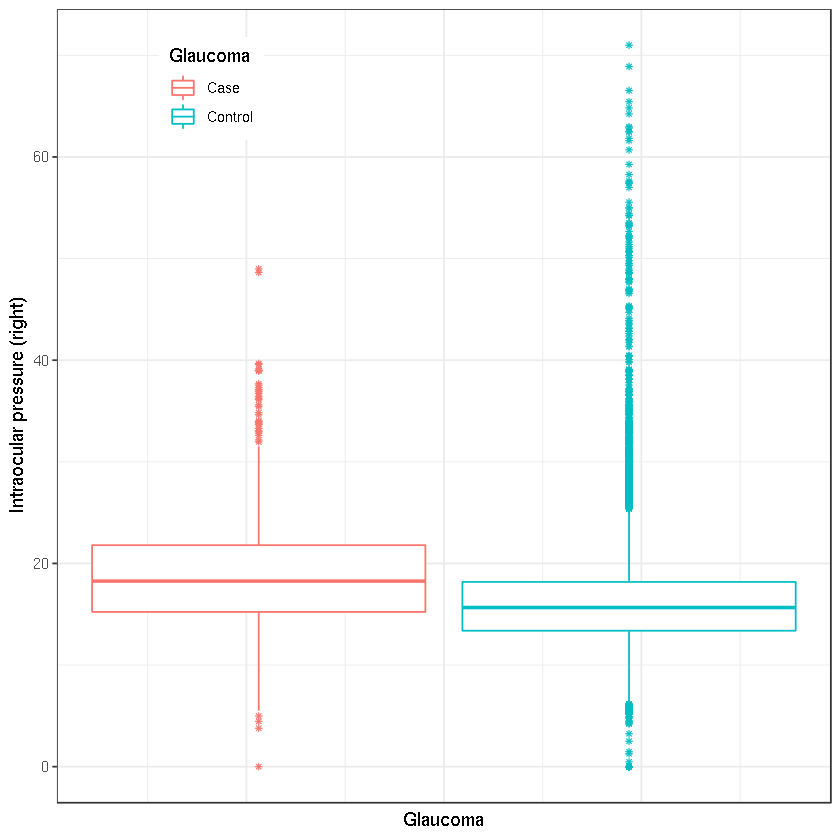

In [17]:
p

In [18]:
ggsave('IOP_distribution.png', p)

Saving 6.67 x 6.67 in image


In [19]:
merged %>% count(rs28991009_G)

rs28991009_G,n
0,28
1,5410
2,331239
NA,474


In [20]:
merged %>% filter(
    age_death != -9,
    rs28991009_G == 0
) %>% arrange(-age_death) %>% 
head(0) # individual level data should not be saved as a part of notebook

FID,IID,IOP,Glaucoma,IOP_measured,Year_of_birth,age_death,rs28991009_G


In [21]:
merged %>% filter(
#     age_death != -9,
    rs28991009_G == 0
) %>% arrange(-age_death, Year_of_birth) %>% 
head(0) # individual level data should not be saved as a part of notebook

FID,IID,IOP,Glaucoma,IOP_measured,Year_of_birth,age_death,rs28991009_G
